In [119]:
from nltk.tokenize import word_tokenize # or use some other tokenizer
from nltk.corpus import stopwords

from sklearn import svm, datasets, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from datetime import date

import string
import random
import nltk
import pickle
import itertools


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




def document_features(document):
    document_words = document.split()
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
youtube_data = pd.read_pickle("sponAndNotYoutube_scrape.pickle")

In [4]:
sample_size = 50
not_spon = [index for index, item in enumerate(youtube_data.sponsored) if item == 'no']
not_spon_sample = random.sample(not_spon,sample_size)
spon = [index for index, item in enumerate(youtube_data.sponsored) if item == 'yes']
spon_sample = random.sample(spon,sample_size)

In [5]:
train = youtube_data.iloc[not_spon_sample + spon_sample, :]
train.head()

,channel,title,video_id,description,caption,fullCaptions,sponsored
188,Rosy JulieBC,Substance Natural Sunscreen Review on Sensitiv...,a4zWI3k_9GI,Here's what I thought of Substance natural sun...,"1\n00:00:10,250 --> 00:00:15,269\nhi Rosie fri...",hi Rosie friends it's Julie and today I'm goin...,no
428,crocman132,BEST GAME SITE EVER! | BARBIE GAMES! (Not spon...,zCPi46FWqq8,►I GOT BORED SO I DECIDED TO PLAY BARBIE GAMES...,"1\n00:00:00,270 --> 00:00:03,620\n[Music]\n\n2...",[Music] hello everybody crackdown 132 here bac...,no
18,QueenDebbie,WTF FASHION NOVA | MY EXPERIENCE *NOT SPONSORED*,zYb_n4MP2oI,"COMMENT,LIKE ,AN SUBSCRIBE\n------------------...","1\n00:00:01,060 --> 00:00:05,890\n[Music]\n\n2...",[Music] to provide you with an amazing challen...,no
32,fit_geo,NOT Sponsored Gymshark Haul & Review With Meas...,ci-R2CnyDpo,Hey guys! Finally figuring out some of this ed...,"1\n00:00:00,860 --> 00:00:09,389\nwhat's up gu...",what's up guys so I got a super huge kind of u...,no
233,Rosy JulieBC,Rosacea Friendly Smoothie Recipe (not sponsore...,VmsMYFSGC7g,This recipe is packed with anti-inflammatory i...,"1\n00:00:08,300 --> 00:00:12,090\npussy friend...",pussy friends it's Julie and today's video it'...,no


In [6]:
spon_test =  random.sample(list(set(spon) - set(spon_sample)),10)
not_spon_test =  random.sample(list(set(not_spon) - set(not_spon_sample)),10)
test = youtube_data.iloc[not_spon_test + spon_test, :]

10
10


# tokenized features Naive Bayes

In [187]:
stop = stopwords.words('english') + list(string.punctuation)

In [188]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [189]:
train_tokens = []
for sentence in train.fullCaptions:
    train_tokens.append([i for i in word_tokenize(sentence.lower()) if i not in stop])

In [190]:
words = [y for x in train_tokens for y in x]

In [191]:
all_words = nltk.FreqDist(w.lower() for w in words)
word_features = list(all_words)

In [192]:
filename = 'dictionary_scrape.sav'
pickle.dump(word_features, open(filename, 'wb'))

In [193]:
feature_set = []
for i in range(len(train)):
    feature_set.append((document_features(train.fullCaptions.iloc[i]), 
           train.sponsored.iloc[i]))

In [195]:
classifier = nltk.NaiveBayesClassifier.train(feature_set)

In [196]:
classifier.show_most_informative_features()

Most Informative Features
         contains(games) = True              yes : no     =     11.0 : 1.0
        contains(gentle) = True               no : yes    =      8.3 : 1.0
           contains(oil) = True               no : yes    =      8.3 : 1.0
          contains(skin) = True               no : yes    =      8.1 : 1.0
             contains(5) = True              yes : no     =      7.7 : 1.0
          contains(rate) = True              yes : no     =      7.7 : 1.0
      contains(thousand) = True              yes : no     =      7.0 : 1.0
          contains(soap) = True               no : yes    =      7.0 : 1.0
        contains(thanks) = True              yes : no     =      6.7 : 1.0
        contains(custom) = True              yes : no     =      6.3 : 1.0


In [20]:
test_feature_set = []
for i in range(len(test)):
    test_feature_set.append((document_features(test.fullCaptions.iloc[i]), 
           test.sponsored.iloc[i]))
    
    
nltk.classify.accuracy(classifier, test_feature_set)

0.7

In [22]:
classifier.classify(document_features(test.fullCaptions.iloc[1]))

'yes'

In [32]:
np.array([classifier.prob_classify(document_features(cap)).prob('yes') for cap in test.fullCaptions]).round(2)

array([ 1.  ,  1.  ,  0.  ,  0.13,  0.  ,  1.  ,  1.  ,  0.  ,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,
        1.  ,  1.  ])

In [43]:
classes_test_set = [classifier.classify(document_features(cap)) for cap in test.fullCaptions]

In [51]:
cnf_matrix = confusion_matrix(test.sponsored, classes_test_set, labels = ["yes", "no"])

Confusion matrix, without normalization
[[10  0]
 [ 6  4]]


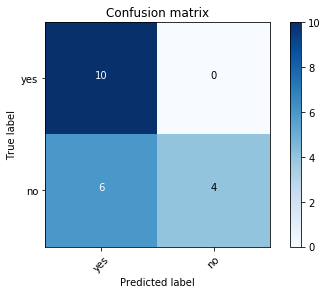

In [56]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["yes", "no"])
plt.show()

# tf-idf featurization

In [254]:
# convert to feature vector
feature_extraction = TfidfVectorizer(stop_words = 'english',token_pattern=u'(?ui)\\b\\w*[a-z]{3,}\\w*\\b', lowercase =True)
X_train = feature_extraction.fit_transform(train.fullCaptions)
X_test = feature_extraction.transform(test.fullCaptions)
print(X_train.shape)
print(X_test.shape)

(100, 9903)
(20, 9903)


In [255]:
Y_train = train.sponsored
Y_test = test.sponsored

binarize = preprocessing.LabelBinarizer()
y_train = np.ravel(binarize.fit_transform(Y_train))
y_test = np.ravel(binarize.transform(Y_test))

print(Y_test)
print(y_test)

405     no
49      no
181     no
319     no
183     no
71      no
117     no
128     no
135     no
322     no
120    yes
314    yes
248    yes
173    yes
85     yes
134    yes
161    yes
102    yes
95     yes
110    yes
Name: sponsored, dtype: object
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


## tf-idf SVM

In [256]:
# train classifier
clf = SVC(probability=True, kernel='rbf')
clf.fit(X_train, y_train)

# predict and evaluate predictions
predictions_prob = clf.predict_proba(X_test)
predictions_prob

array([[ 0.51380421,  0.48619579],
       [ 0.51386891,  0.48613109],
       [ 0.51380834,  0.48619166],
       [ 0.51385724,  0.48614276],
       [ 0.51381866,  0.48618134],
       [ 0.51388387,  0.48611613],
       [ 0.51380336,  0.48619664],
       [ 0.51380741,  0.48619259],
       [ 0.51386658,  0.48613342],
       [ 0.51381702,  0.48618298],
       [ 0.51389051,  0.48610949],
       [ 0.51385157,  0.48614843],
       [ 0.51387321,  0.48612679],
       [ 0.51387808,  0.48612192],
       [ 0.51389184,  0.48610816],
       [ 0.51387743,  0.48612257],
       [ 0.51387393,  0.48612607],
       [ 0.51389675,  0.48610325],
       [ 0.5138749 ,  0.4861251 ],
       [ 0.51389392,  0.48610608]])

In [257]:
# predict and evaluate predictions
predictions = clf.predict(X_test)
predictions

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [258]:
y_test, predictions

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [259]:
roc_auc_score(y_test, predictions)

0.80000000000000004

In [260]:
roc_auc_score(y_test, predictions_prob[:,0])

0.91000000000000003

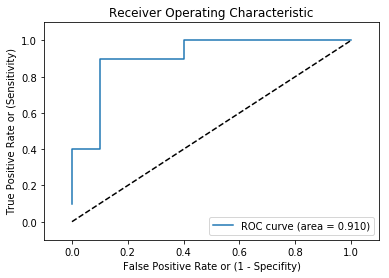

In [261]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob[:,0])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

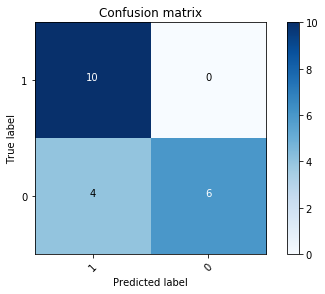

In [262]:
cnf_matrix = confusion_matrix(y_test, predictions, labels = [1, 0])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0])
plt.show()

## tf-idf Naive Bayes

In [263]:
bernNB = BernoulliNB()
gausNB = GaussianNB()

bernNB.fit(X_train.toarray(), y_train)
gausNB.fit(X_train.toarray(), y_train)

GaussianNB(priors=None)

In [264]:
predictions_prob_bNB = bernNB.predict_proba(X_test)
predictions_bNB = bernNB.predict(X_test)
print(predictions_prob_bNB[:,0], predictions_bNB)
roc_auc_score(y_test, predictions_bNB)

[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00   9.78401657e-01   1.00000000e+00
   1.66521848e-61   1.00000000e+00   9.99877492e-01   4.11825295e-27
   9.99999967e-01   2.50501065e-32   1.00000000e+00   2.30978840e-12] [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1]


0.69999999999999996

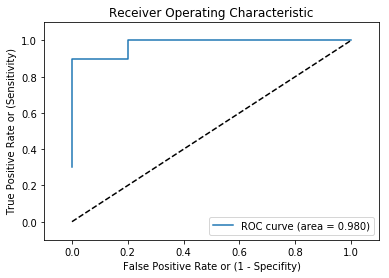

In [265]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob_bNB[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

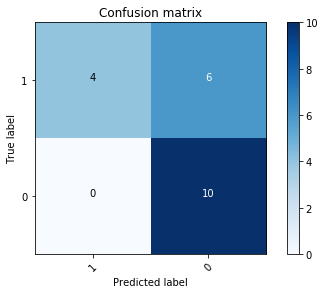

In [266]:
cnf_matrix = confusion_matrix(y_test, predictions_bNB, labels = [1, 0])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0])
plt.show()

In [267]:
predictions_prob_gNB = gausNB.predict_proba(X_test.toarray())
predictions_gNB = gausNB.predict(X_test.toarray())
print(y_test,predictions_prob_gNB[:,0], predictions_gNB)
roc_auc_score(y_test, predictions_gNB)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1] [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.] [0 1 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


0.84999999999999998

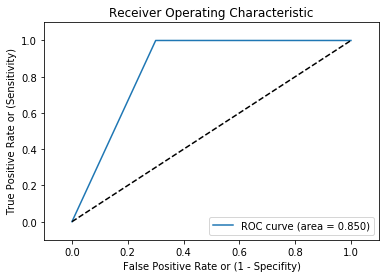

In [268]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob_gNB[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

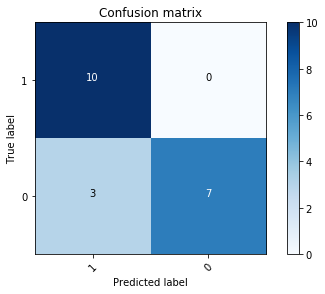

In [269]:
cnf_matrix = confusion_matrix(y_test, predictions_gNB, labels = [1, 0])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1, 0])
plt.show()

In [272]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [273]:
show_most_informative_features(feature_extraction, bernNB, n=20)

	-3.9512	aaron          		-0.0392	like           
	-3.9512	abhilasha      		-0.0594	just           
	-3.9512	abiding        		-0.0800	video          
	-3.9512	abilities      		-0.0800	time           
	-3.9512	absorbing      		-0.0800	right          
	-3.9512	absorbs        		-0.1446	let            
	-3.9512	accentuating   		-0.1446	guys           
	-3.9512	accept         		-0.1671	know           
	-3.9512	accession      		-0.1671	don            
	-3.9512	accessory      		-0.1900	way            
	-3.9512	ached          		-0.1900	want           
	-3.9512	acid           		-0.1900	really         
	-3.9512	acidic         		-0.1900	little         
	-3.9512	actuate        		-0.1900	good           
	-3.9512	adalind        		-0.2136	make           
	-3.9512	adaline        		-0.2136	going          
	-3.9512	adaptation     		-0.2377	pretty         
	-3.9512	addiction      		-0.2377	got            
	-3.9512	additionally   		-0.2624	think          
	-3.9512	adeline        		-0.2624	thing          
